In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertModel, BertConfig
import sklearn
from sklearn import metrics
import numpy as np

In [3]:
#pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.2 MB/s eta 0:00:00


In [4]:
#!pip install openpyxl


In [5]:
from skmultilearn.model_selection import iterative_train_test_split

In [6]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [7]:
df = pd.read_excel("/content/drive/My Drive/Datasets/oversampled_dataset.xlsx")
df['list'] = df[df.columns[1:]].values.tolist()
new_df = df[['Title', 'list']].copy()
new_df.head()

,Title,list
0,Project Manager Finance/Wealth Management Area,"[0, 1, 0, 0, 0, 0]"
1,CFO/Deputy CEO,"[0, 0, 0, 0, 1, 0]"
2,Web Application Developer,"[0, 0, 1, 0, 0, 0]"
3,"Director Customer Success / Sr. Manager, Commu...","[0, 1, 0, 1, 0, 0]"
4,Executive Partner and CTO,"[0, 0, 0, 0, 1, 0]"


In [8]:
idx = new_df.index
text = new_df['Title']
labels = new_df['list']

In [9]:
print(text)

0          Project Manager Finance/Wealth Management Area
1                                          CFO/Deputy CEO
2                               Web Application Developer
3       Director Customer Success / Sr. Manager, Commu...
4                               Executive Partner and CTO
                              ...                        
2371                                    managing director
2372                     SVP, Senior Credit Administrator
2373                                  Data Repair Analyst
2374    Head of International Product and Marketing Ma...
2375                    Vice President/Operations Manager
Name: Title, Length: 2376, dtype: object


In [10]:
labels = np.array([np.array(label, dtype=int) for label in labels])
print(labels)

[[0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 1 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [1 1 0 0 0 0]]


In [12]:
# create label weights
label_weights = 1 - labels.sum(axis=0) / labels.sum()

#from sklearn.utils.class_weight import compute_class_weight
#label_weights = compute_class_weight('balanced', classes=[0, 1], y=labels.flatten())
#label_weights = torch.tensor(label_weights).float().to(device)

In [13]:
# stratified train-val-test split for multilabel dataset
row_ids = np.arange(len(labels))
train_idx, y_train, remaining_idx, y_remaining = iterative_train_test_split(row_ids[:,np.newaxis], labels, test_size = 0.2)
val_idx, y_val, test_idx, y_test = iterative_train_test_split(remaining_idx[:,np.newaxis], y_remaining, test_size = 0.5)

# Extract corresponding texts for each split
x_train = [text[i] for i in train_idx.flatten()]
x_val = [text[i] for i in val_idx.flatten()]
x_test = [text[i] for i in test_idx.flatten()]


In [14]:
# Configuration
MAX_LEN = 200
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=200):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(self.labels[index], dtype=torch.float)
        }

# Create datasets
train_dataset = CustomDataset(x_train, y_train, tokenizer, max_len=MAX_LEN)
val_dataset = CustomDataset(x_val, y_val, tokenizer, max_len=MAX_LEN)
test_dataset = CustomDataset(x_test, y_test, tokenizer, max_len=MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [16]:
print("FULL Dataset: {}".format(len(x_train) + len(x_val) + len(x_test)))
print("TRAIN Dataset: {}".format(len(train_dataset)))
print("VALIDATION Dataset: {}".format(len(val_dataset)))
print("TEST Dataset: {}".format(len(test_dataset)))

FULL Dataset: 2376
TRAIN Dataset: 1901
VALIDATION Dataset: 239
TEST Dataset: 236


In [17]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, num_labels)

    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

# Initialize model with number of labels
num_labels = y_train.shape[1]
model = BERTClass(num_labels)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [18]:
# Loss function with class weights
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(weight=torch.tensor(label_weights).to(device))(outputs, targets)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [19]:
# Lists to track metrics during training
train_losses = []
val_losses = []
accuracies = []
f1_micro_scores = []
f1_macro_scores = []

In [20]:
# Training function
def train(epoch):
    model.train()
    train_loss = 0
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        #if _%500==0:
            #print(f'Epoch: {epoch}, Loss: {loss.item()}')

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    #train_losses.append(epoch_loss / len(train_loader))
    return train_loss / len(train_loader)

In [25]:
# Validation function
def validation(epoch):
    model.eval()
    val_loss = 0
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            outputs = model(ids, mask, token_type_ids)

            #loss = loss_fn(outputs, targets)
            #val_loss += loss.item()
            val_loss += loss_fn(outputs, targets).item()
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    fin_outputs = np.array(fin_outputs) >= 0.5
    f1_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')

    #return fin_outputs, fin_targets
    return val_loss / len(val_loader), f1_micro, f1_macro

In [27]:
# Training loop

train_losses = []
val_losses = []
f1_scores_micro = []
f1_scores_macro = []

for epoch in range(EPOCHS):
    #train(epoch)
    #outputs, targets = validation(epoch)

    train_loss = train(epoch)
    val_loss, f1_micro, f1_macro = validation(epoch)

    # Convert to binary predictions
    #outputs = np.array(outputs) >= 0.5
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores_micro.append(f1_micro)
    f1_scores_macro.append(f1_macro)
    # Calculate metrics
    #accuracy = metrics.accuracy_score(targets, outputs)
    #f1_micro = metrics.f1_score(targets, outputs, average='micro')
    #f1_macro = metrics.f1_score(targets, outputs, average='macro')

    #print(f"Accuracy Score = {accuracy}")
    #print(f"F1 Score (Micro) = {f1_micro}")
    #print(f"F1 Score (Macro) = {f1_macro}")
    #print(f"Hamming Loss = {hamming_loss}")

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Micro: {f1_micro:.4f}, F1 Macro: {f1_macro:.4f}")

Epoch 1/8, Train Loss: 0.0850, Val Loss: 0.0601, F1 Micro: 0.9632, F1 Macro: 0.9517
Epoch 2/8, Train Loss: 0.0664, Val Loss: 0.0632, F1 Micro: 0.9441, F1 Macro: 0.9333
Epoch 3/8, Train Loss: 0.0558, Val Loss: 0.0595, F1 Micro: 0.9385, F1 Macro: 0.9226
Epoch 4/8, Train Loss: 0.0435, Val Loss: 0.0559, F1 Micro: 0.9412, F1 Macro: 0.9188
Epoch 5/8, Train Loss: 0.0385, Val Loss: 0.0535, F1 Micro: 0.9560, F1 Macro: 0.9403
Epoch 6/8, Train Loss: 0.0286, Val Loss: 0.0524, F1 Micro: 0.9540, F1 Macro: 0.9380
Epoch 7/8, Train Loss: 0.0276, Val Loss: 0.0501, F1 Micro: 0.9542, F1 Macro: 0.9413
Epoch 8/8, Train Loss: 0.0190, Val Loss: 0.0453, F1 Micro: 0.9484, F1 Macro: 0.9345


In [28]:
# Save the model
torch.save(model.state_dict(), "MyBert_multilabel_model.pt")
print("Model saved successfully!")

Model saved successfully!


In [29]:
# Testing function
def test_model(test_loader, model):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets']

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    fin_outputs = np.array(fin_outputs) >= 0.5
    accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
    f1_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
    f1_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro')

    print("Test Metrics:")
    print(f"Accuracy = {accuracy:.4f}")
    print(f"F1 Micro = {f1_micro:.4f}")
    print(f"F1 Macro = {f1_macro:.4f}")


In [30]:
# Test the model
test_model(test_loader, model)

Test Metrics:
Accuracy = 0.8814
F1 Micro = 0.9160
F1 Macro = 0.8935


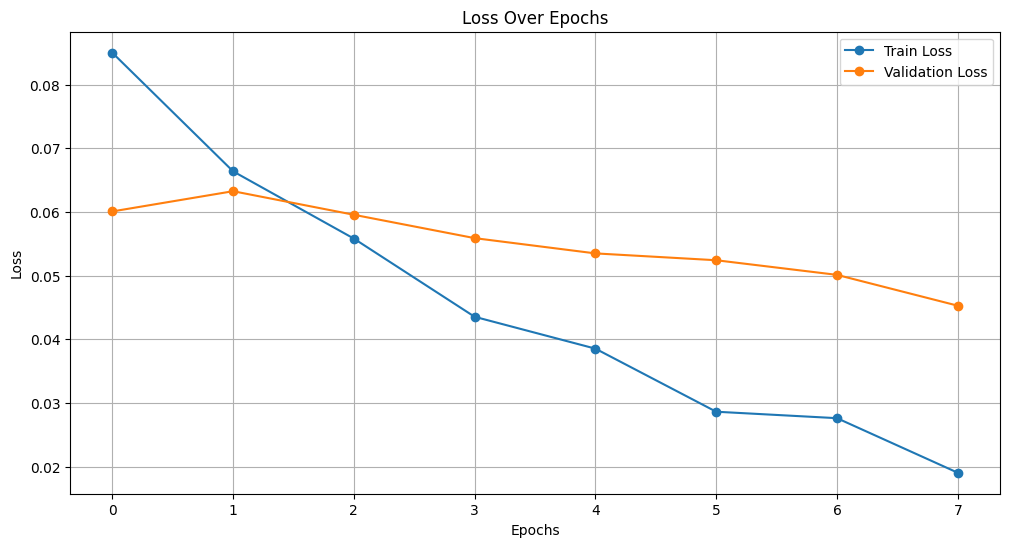

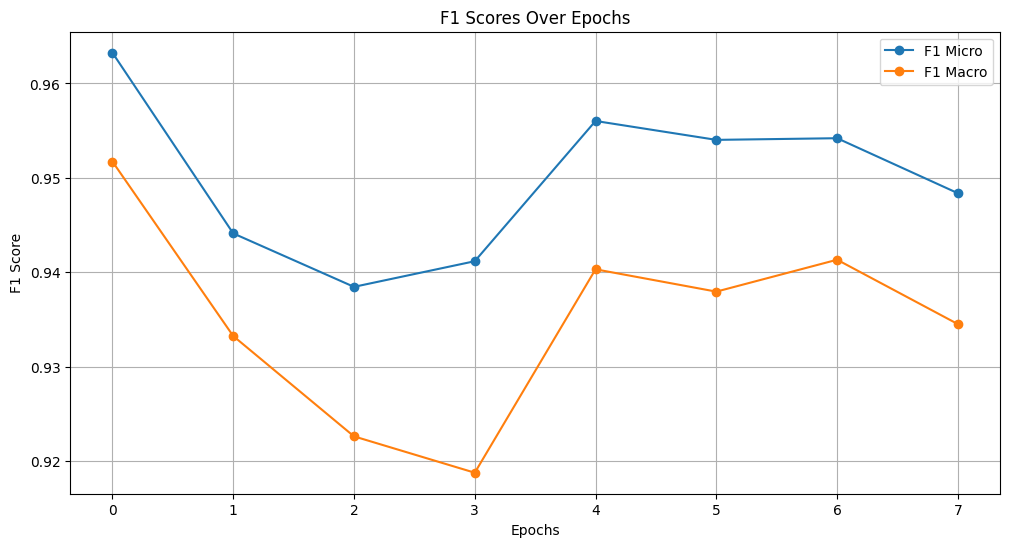

In [31]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(f1_scores_micro, label="F1 Micro", marker='o')
plt.plot(f1_scores_macro, label="F1 Macro", marker='o')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Scores Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [32]:
from google.colab import files

files.download('MyBert_multilabel_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>